In [1]:
from utils import *

In [2]:
combined_all_dataframes = get_postProcessedData()

In [3]:
feature_df = calculate_features_from_df(combined_all_dataframes, True, True)

index 0 is out of bounds for axis 0 with size 0
WARNING, failed to caluclate for Participant: Participant15 on Image: 35
index 0 is out of bounds for axis 0 with size 0
WARNING, failed to caluclate for Participant: Participant15 on Image: 102
index 0 is out of bounds for axis 0 with size 0
WARNING, failed to caluclate for Participant: Participant15 on Image: 18
index 0 is out of bounds for axis 0 with size 0
WARNING, failed to caluclate for Participant: Participant15 on Image: 84


In [4]:
participant_data = pd.read_csv(os.path.join("processed_data", "participants_data", "participantData.csv"), index_col=0)
participant_data.head(5)

,Participant name,Age,Gender,Using Glasses/Contacts?,Average calibration accuracy (degrees),Average calibration precision SD (degrees),Average validation precision SD (mm),Average validation accuracy (degrees)
0,Participant1,30 - 40,Female,No,"0,64",NaN,"1,8","0,44"
60460,Participant2,20 - 30,Female,Yes,"3,95",NaN,"1,9","0,79"
119128,Participant3,20 - 30,Male,Yes,NaN,NaN,NaN,NaN
136735,Participant3,20 - 30,Male,Yes,"1,30",NaN,"4,8","0,78"
214970,Participant4,20 - 30,Male,No,"0,60",NaN,"1,8","0,43"


In [5]:
from gazeheatplot_script import *

In [6]:
combined_all_dataframes = combined_all_dataframes.merge(participant_data, left_on='Participant', right_on='Participant name')

In [12]:
def plot_average_heatmap(recording_df, image_n, gaussianwh=100):
    # Gazeheatplot is based on https://github.com/TobiasRoeddiger/GazePointHeatMap
    stimulus_mask = ((recording_df["Image_n"] == image_n)).to_numpy(dtype=bool)
    trial_data = recording_df.iloc[stimulus_mask,:]
    trial_names = np.unique(trial_data["Stimulus_name"])
    trial_name = trial_names[0] if ("_present_" in trial_names[0] or "_in_" in trial_names[0]) else trial_names[1]
    img_name = trial_name
    mask_name = get_mask_name(trial_name)
    to_plot_dataset = pd.DataFrame(columns=recording_df.columns)
    for participant in recording_df["Participant"].unique():
        trial_rep = recording_df[((recording_df.Participant == participant) 
                        & (recording_df['Image_n'] == image_n) 
                        & (recording_df['Mouse_Confirm_Trial'] == False))]

        fix_time_filter = trial_rep['Event_time'].max() 
        response_time = trial_rep['Response_time'].min()
        if not pd.isnull(response_time):
            when_spot = trial_rep['Response_time'].argmin()
            fix_time_filter = trial_rep.iloc[when_spot]["Event_time"]
        fixation_data = trial_rep[(trial_rep['Event_type'] == "Fixation") & (trial_rep['Event_time'] <= fix_time_filter)]
        to_plot_dataset = pd.concat([to_plot_dataset,fixation_data])
    fixation_data = to_plot_dataset[(to_plot_dataset.Event_type == "Fixation") & (to_plot_dataset["Mouse_Confirm_Trial"] == False)].loc[:,["Fixation_X'","Fixation_Y'", "Fixation_duration"]].to_numpy(dtype=int)
    draw_heatmap(fixation_data, (IMAGE_X_SIZE, IMAGE_Y_SIZE), imagefile=os.path.join(DATASET_DIR, "Images", f"{img_name}.jpg"), maskfile=mask_name, alpha=0.5,
                                 savefilename=None, gaussianwh=gaussianwh, gaussiansd=None)
    plt.plot()


['0102_R_mirrorONLY_in_shoppingbag'
 '0102_R_mirrorONLY_neither_shoppingbag']


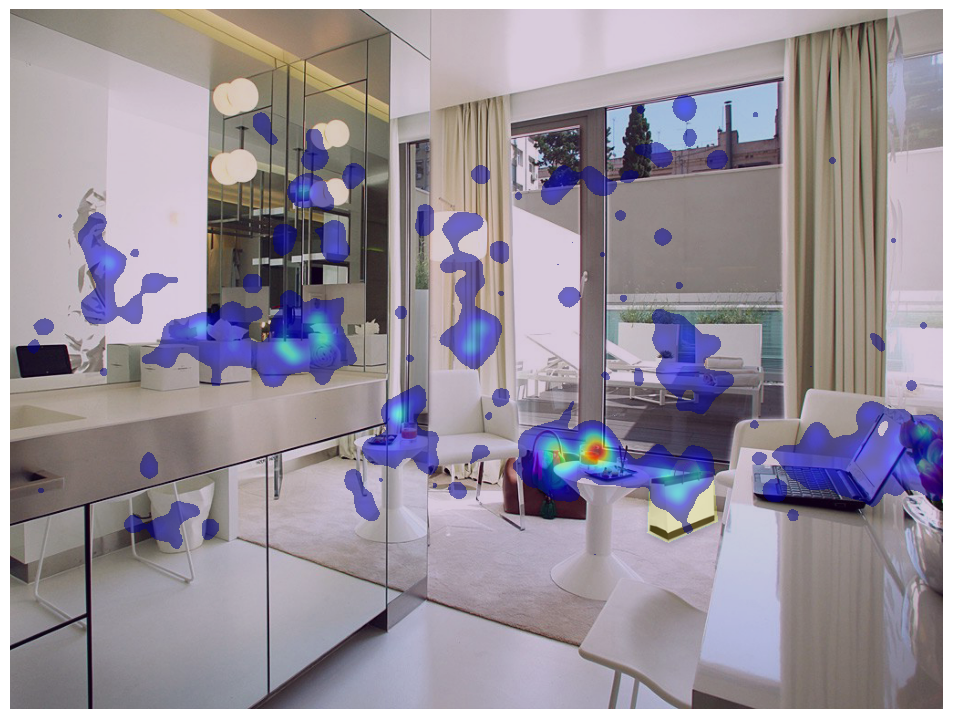

In [18]:
plot_average_heatmap(combined_all_dataframes, 102	, 50)

In [83]:
import matplotlib.patheffects as PathEffects

In [84]:

def plot_data_from_recording_df_img_n(recording_df, participant_name, image_n, repetition="ALL", trials_to_plot="BOTH"):
    assert participant_name in recording_df["Participant"].unique()
    assert trials_to_plot in ["BOTH","CONFIRM", "REPETITION"], "trials_to_plot needs to be in [BOTH, CONFIRM, REPETITION]."
    if trials_to_plot == "BOTH":
        assert repetition == "ALL", "trials_to_plot==BOTH does not suport filtering on repetitions."
    if trials_to_plot == "REPETITION":
        assert type(repetition) == int, "repetition needs to be an integer >= 0 AND <= 2 ."
        assert repetition >= 0 and repetition <= 2, "repetition needs to be an integer >= 0 AND <= 2 ."
    if trials_to_plot == "CONFIRM":
        assert repetition == 0 or repetition == "ALL", "If using trials_to_plt==CONFIRM; repetition needs to be set to ALL or 0"
    if trials_to_plot == "BOTH":
        print("INFO: When plotting BOTH, the fixations are only from the repetition trials.")
        stimulus_mask = (recording_df["Image_n"] == image_n).to_numpy(dtype=bool)
    elif trials_to_plot == "CONFIRM":
        stimulus_mask = ((recording_df["Image_n"] == image_n) & (recording_df["Mouse_Confirm_Trial"] == True)).to_numpy(dtype=bool)
    else:
        stimulus_mask = ((recording_df["Image_n"] == image_n) & (recording_df["Repetition_n"] == repetition) & (recording_df["Mouse_Confirm_Trial"] == False)).to_numpy(dtype=bool)
        
    stimulus_mask = (stimulus_mask & (recording_df["Participant"] == participant_name)).to_numpy(dtype=bool)
    trial_data = recording_df.iloc[stimulus_mask,:]
    if trials_to_plot == "BOTH":
        fixation_data = trial_data[(trial_data.Event_type == "Fixation") & (trial_data["Mouse_Confirm_Trial"] == False)].loc[:,["Fixation_X","Fixation_Y", "Fixation_duration"]].to_numpy(dtype=int)
    else:
        fixation_data = trial_data[(trial_data.Event_type == "Fixation")].loc[:,["Fixation_X","Fixation_Y", "Fixation_duration"]].to_numpy(dtype=int)
    mouse_points = trial_data[trial_data.Event_type == "MouseClick"].loc[:,["Mouse_X","Mouse_Y"]].to_numpy(dtype=int)
    fixation_points = fixation_data[:, :-1]
    fix_duration_size = fixation_data[:, -1]
    # These values are always the same, they are taken by checking the
    # presented media positions
    fixation_points[:,0] = fixation_points[:,0] - 448
    fixation_points[:,1] = fixation_points[:,1] - 156
    trial_names = np.unique(trial_data["Stimulus_name"])
    trial_name = trial_names[0] if ("_present_" in trial_names[0] or "_in_" in trial_names[0]) else trial_names[1]
    centerMass_x, centerMass_y = trial_data[trial_data.Event_type == "Fixation"][['Center_mass_X','Center_mass_Y']].iloc[0]
    img_name = trial_name
    if "practice" in img_name:
        print("Error: Practice images have no mask.")
        return
    x_inside_image = fixation_points[:,0] <= IMAGE_X_SIZE
    y_inside_image = fixation_points[:,1] <= IMAGE_Y_SIZE
    
    # Remove points outside the image
    fixation_points = fixation_points[x_inside_image & y_inside_image]
    fix_duration_size = fix_duration_size[x_inside_image & y_inside_image]
    
    mask_name = get_mask_name(trial_name)
    img = plt.imread(os.path.join(DATASET_DIR, "Images", f"{img_name}.jpg"))
    img_mask =  load_mask(os.path.join(DATASET_DIR, "Masks", mask_name))
    fix_in_mask = np.zeros(len(fixation_points), dtype=bool)
    
    for i, point in enumerate(fixation_points):
        if pd.isnull(point[0]):
            continue
        else:
            if is_in_mask(int(point[0]), int(point[1]), img_mask):
                fix_in_mask[i] = True
    
    fix_duration_size = (fix_duration_size/max(fix_duration_size) * 100) * 3
    
    fig, ax = plt.subplots(figsize=(16, 14), dpi=200)
    ax.imshow(img)
    ax.imshow(img_mask, alpha=0.3)
    ax.scatter(fixation_points[fix_in_mask,0], fixation_points[fix_in_mask,1], s=fix_duration_size[fix_in_mask], alpha=0.6, label="Fixation in AoI")
    ax.scatter(fixation_points[~fix_in_mask,0], fixation_points[~fix_in_mask,1], s=fix_duration_size[~fix_in_mask], alpha=0.6, label="Fixation not in AoI")
    ax.scatter(centerMass_x, centerMass_y, alpha=0.5, c="red", s=50, marker="x", label="Center of AoI")
    for i, point in enumerate(fixation_points):
        if i > len(fixation_points) - 5:
            txt = ax.text(point[0], point[1], i, fontsize=12, color="black")
            txt.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='w')])
    if len(mouse_points > 0):
        mouse_points[:,0] = mouse_points[:,0] - 448
        mouse_points[:,1] = mouse_points[:,1] - 156
        mouse_click_in_mask = np.zeros(len(mouse_points), dtype=bool)
        for i, point in enumerate(mouse_points):
            if pd.isnull(point[0]):
                continue
            else:
                try:
                    if is_in_mask(int(point[0]), int(point[1]), img_mask):
                        mouse_click_in_mask[i] = True
                except:
                    print("WARNING: Mouse was clicked outside image area.", mouse_points)
        ax.scatter(mouse_points[mouse_click_in_mask,0], mouse_points[mouse_click_in_mask,1], c="red", s=50, alpha=0.8, marker="X", label="Mouse click in AoI")
        #ax.scatter(mouse_points[~mouse_click_in_mask,0], mouse_points[~mouse_click_in_mask,1], c="blue", s=50, alpha=0.8, marker="X", label="Mouse click outside mask")
    # From: https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.3, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=False, ncol=2)
    plt.axis('off')
    plt.plot()

In [85]:
from matplotlib.pyplot import figure



INFO: When plotting BOTH, the fixations are only from the repetition trials.


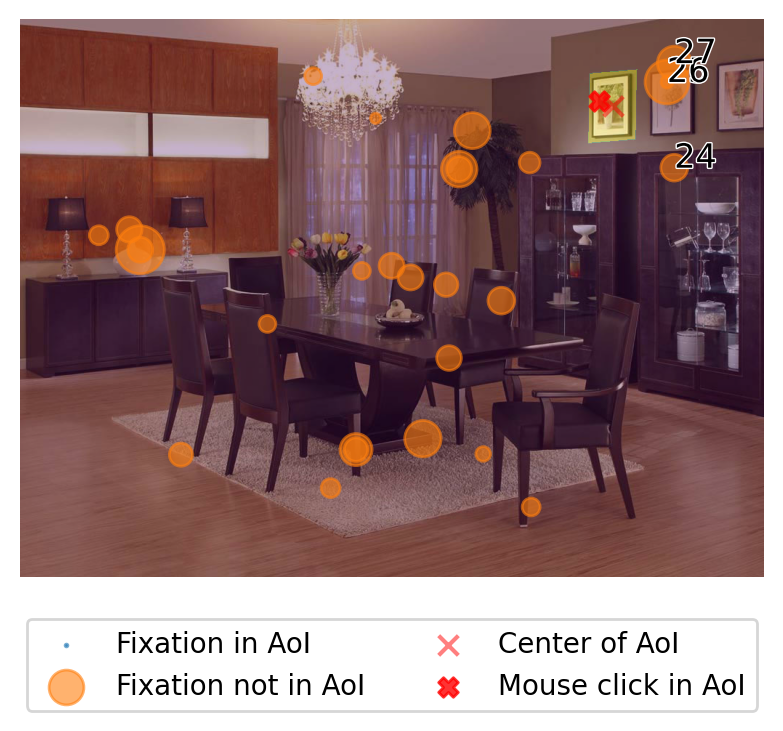

In [86]:
plot_data_from_recording_df_img_n(combined_all_dataframes, "Participant7", 40)